In [25]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
import pickle
import nltk
import tensorflow
import tensorflow.keras as keras
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU

In [2]:
# read data
train_data = pd.read_csv("../Data/train.csv")
test_data = pd.read_csv("../Data/test.csv")

In [3]:
#Parse dataset -- In total : 28619 samples

# get stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on headline column
train_data['headline']=train_data['headline'].apply(denoise_text)
test_data['headline']=test_data['headline'].apply(denoise_text)

In [4]:
#lemmatize (normalize) the text by leveraging the popular spaCy library by importing spaCy's language model

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

#lemmatize train and test data
train_data['headline'] = lemmatization(train_data['headline'])
test_data['headline'] = lemmatization(test_data['headline'])

In [5]:
# Split datasets based on test and train
x_train,x_test,y_train,y_test = train_data['headline'],test_data['headline'],train_data['is_sarcastic'],test_data['is_sarcastic']

In [6]:
# Set parameters for tokenizing and sequencing sentences
max_features = 19419
maxlen = 200

In [7]:
# Tokenize sentences
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [9]:
# File containing pretrained glove embeddings
EMBEDDING_FILE = '../Data/glove_embedding200.txt'

In [10]:
# Get embeddings index for faster indexing
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [11]:
# Get embedding vector for model
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/Users/tryptophanv2/opt/anaconda3/envs/elmo/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [12]:
# Set basic model parameters
batch_size = 128
epochs = 2
embed_size = 200

In [13]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          3883800   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 4,220,953
Trainable params: 4,220,953
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Fit dataset to model
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 2)

Train on 21464 samples, validate on 7155 samples
Epoch 1/2
21464/21464 [==============================] - 1274s 59ms/sample - loss: 0.4976 - acc: 0.7575 - val_loss: 0.4322 - val_acc: 0.8151
Epoch 2/2
21464/21464 [==============================] - 1278s 60ms/sample - loss: 0.2695 - acc: 0.8887 - val_loss: 0.4443 - val_acc: 0.8211


In [17]:
# Get accuracy on test set
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

7155/7155 [==============================] - 358s 50ms/sample - loss: 0.4443 - acc: 0.8211
Accuracy of the model on Testing Data is -  82.1104109287262


In [21]:
# Get prediction probabilities
pred_probs = model.predict_proba(X_test)

In [22]:
pred_probs

array([[0.00900248],
       [0.04467237],
       [0.91838944],
       ...,
       [0.86056477],
       [0.99777126],
       [0.18799572]], dtype=float32)

In [26]:
# Dump prediction probabilities
def dump_probs(pred_probs=pred_probs):
    with open('./probs_for_1.pkl','wb') as f:
        pickle.dump(pred_probs,f)

In [29]:
# Get classification report 
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.79      0.87      0.83      3746
    Sarcastic       0.84      0.75      0.79      3409

     accuracy                           0.81      7155
    macro avg       0.82      0.81      0.81      7155
 weighted avg       0.81      0.81      0.81      7155



<AxesSubplot:>

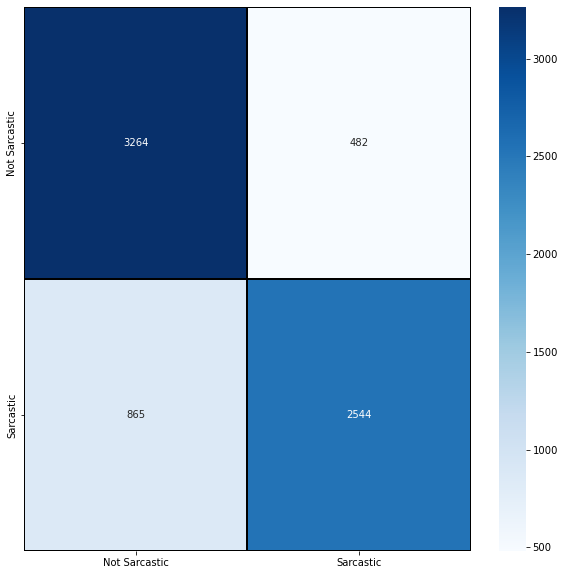

In [31]:
# Plot the confusion matrix
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])